In [135]:
# I will run 4 simulators on random circuits and log the time and memory

In [136]:
import time
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import quimb as qu
import matplotlib.pyplot as plt
import quimb.tensor as qut
from qtn_sim import *
from rdbmsSimulator.sqlite_mps import *

MAXIMUM_BOND_DIMENSION = 5


In [137]:
def myCircuitToQiskit(circuit : QCircuit, n):
    num_qubits = n
    qiskit_circuit = QuantumCircuit(num_qubits)

    for gate, indices in circuit.gateList:
        name = gate.id
        qubits = indices
        params = gate.params
        
        if name == 'H':
            qiskit_circuit.h(qubits[0])
        elif name == 'X':
            qiskit_circuit.x(qubits[0])
        elif name == 'Y':
            qiskit_circuit.y(qubits[0])
        elif name == 'Z':
            qiskit_circuit.z(qubits[0])
        elif name == 'S':
            qiskit_circuit.s(qubits[0])
        elif name == 'T':
            qiskit_circuit.t(qubits[0])
        elif name == 'CNOT':
            qiskit_circuit.cx(qubits[0], qubits[1])
        elif name == 'SWAP':
            qiskit_circuit.swap(qubits[0], qubits[1])
        elif name == 'CP':
            qiskit_circuit.cp(params[0], qubits[0], qubits[1])
        elif name == 'CZ':
            qiskit_circuit.cz(qubits[0], qubits[1])
        elif name == 'CRY':
            qiskit_circuit.cry(params[0], qubits[0], qubits[1])
        elif name == 'TOFFOLI' or name == 'CCX':
            qiskit_circuit.ccx(qubits[0], qubits[1], qubits[2])
        else:
            raise ValueError(f"Unsupported gate: {name}")
    simulator = AerSimulator(method='matrix_product_state', matrix_product_state_max_bond_dimension=MAXIMUM_BOND_DIMENSION)
    return [qiskit_circuit, simulator]
    
def runQiskitSimulation(qiskit_circuit, simulator):
    return simulator.run(transpile(qiskit_circuit))

def quimbMPSSimulator(num_qubits):
    return qut.CircuitMPS(N=num_qubits, max_bond=MAXIMUM_BOND_DIMENSION)

def runQuimbSimulatorSequential(c : qut.CircuitMPS, circuit : QCircuit):
    for gate, indices in circuit.gateList:
        c.apply_gate(gate_id=gate.id, params=gate.params,qubits=indices)
    return c

def myCircuitToSqlLiteJson(n, circuit: QCircuit):
    gateList = []
    for (gate, indices) in circuit.gateList:
        gateList.append({
            "qubits":indices,
            "gate":gate.id,
            "parameters":gate.params
        })
    json = {
        "number_of_qubits": n,
        "gates": gateList
    }
    return json


In [ ]:
gatesAllowed = {**singleQGateMap, **twoQGateMap}
gatesAllowed.pop('CP', None)
gatesAllowed.pop('RY', None)

numberOfCircuits = 100
# numberOfQubits = 5
maxCircuitDepth = 100
maxNumberOfQubits = 50
# p = 0.0
# circuits = createCircuits(numberOfCircuits=numberOfCircuits, 
#                           numberOfQubits=numberOfQubits, 
#                           maxCircuitDepth=maxCircuitDepth, 
#                           gatesUsed=gatesAllowed, 
#                           probablityOfAdjacent=p, 
#                           filePath="circuits.json")
# circuitsRead = readCircuits("circuits.json")


In [139]:
import random

# Initialize lists
n_list = []
p_list = []
d_list = []

circuits = {
    'circuits':[]
}

# Fill the lists with random values
for _ in range(numberOfCircuits):
    n = random.randint(1, maxNumberOfQubits)  # Random integer for n
    p = random.random()     # Random float for p
    d = random.randint(1, maxCircuitDepth) # Random integer for d
    
    n_list.append(n)
    p_list.append(p)
    d_list.append(d)
    
    circuits['circuits'].append(getRandomCircuit(n, d, gatesUsed=gatesAllowed, probablityOfAdjacent=p)[1])
with open("circuits.json", "w") as f:
    json.dump(circuits, f)
circuitsRead = readCircuits("circuits.json")


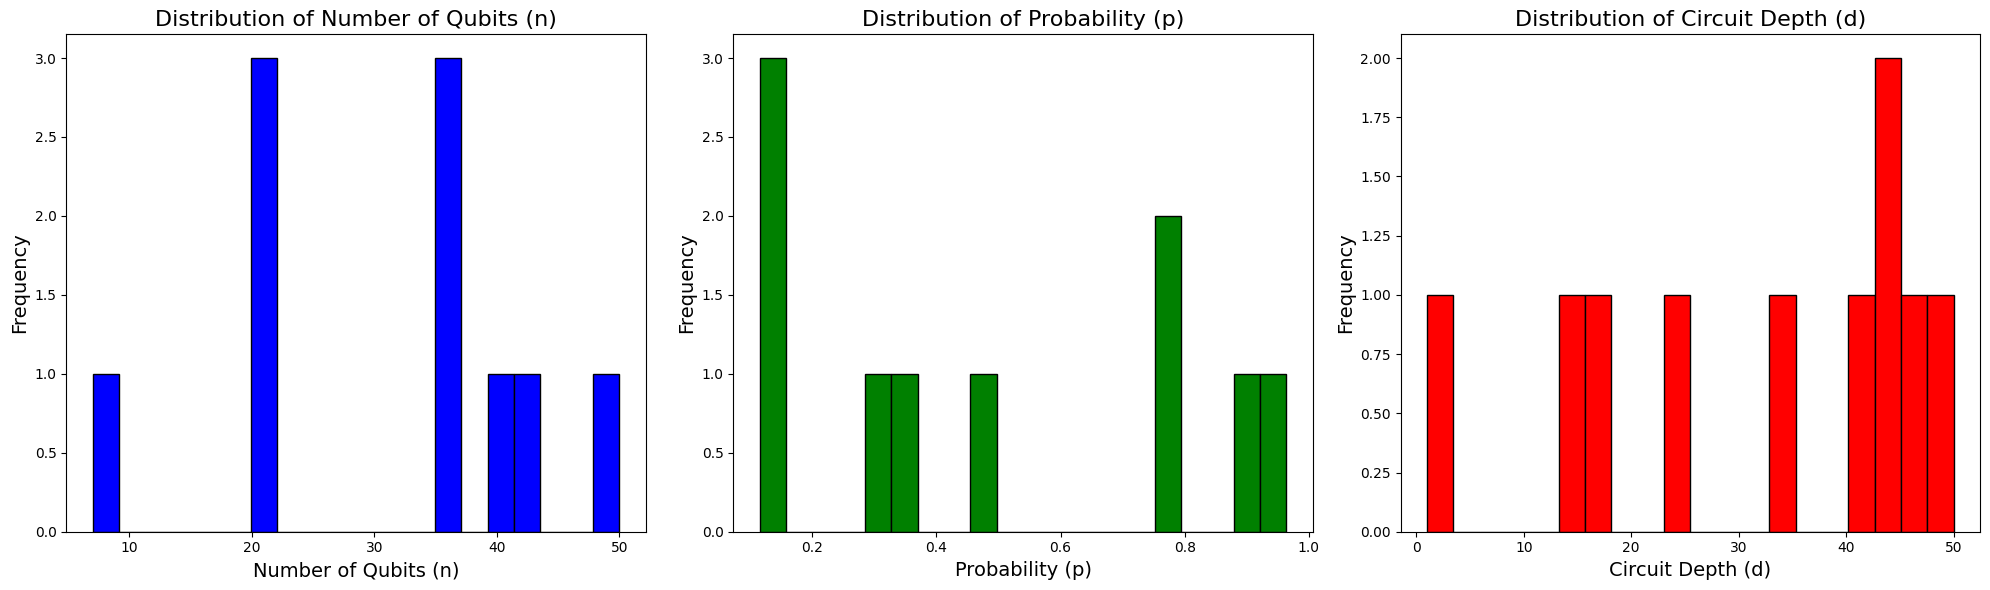

In [140]:
# Draw histogram distributions for n, p, and d
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Histogram for n
axs[0].hist(n_list, bins=20, color='blue', edgecolor='black')
axs[0].set_xlabel('Number of Qubits (n)', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].set_title('Distribution of Number of Qubits (n)', fontsize=16)

# Histogram for p
axs[1].hist(p_list, bins=20, color='green', edgecolor='black')
axs[1].set_xlabel('Probability (p)', fontsize=14)
axs[1].set_ylabel('Frequency', fontsize=14)
axs[1].set_title('Distribution of Probability (p)', fontsize=16)

# Histogram for d
axs[2].hist(d_list, bins=20, color='red', edgecolor='black')
axs[2].set_xlabel('Circuit Depth (d)', fontsize=14)
axs[2].set_ylabel('Frequency', fontsize=14)
axs[2].set_title('Distribution of Circuit Depth (d)', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()

In [141]:
def getTimeMemory(func, args):
    start = time.perf_counter_ns()
    tracemalloc.start()

    func(*args)

    mem = tracemalloc.get_traced_memory()

    tracemalloc.stop()

    end = time.perf_counter_ns()
    timeIt = end - start

    return timeIt, mem[1]


In [142]:
import pandas as pd


# Initialize arrays to store time and memory usage
time_aer = []
mem_aer = []
time_quimb = []
mem_quimb = []
time_qtn_sim = []
mem_qtn_sim = []
time_rdbms = []
mem_rdbms = []

# Iterate over the circuits and run the simulators
for i, circuit in enumerate(circuitsRead):
    # Run AerSimulator
    qiskit_circuitAndAer = myCircuitToQiskit(circuit, n_list[i])
    time_it, mem = getTimeMemory(runQiskitSimulation, qiskit_circuitAndAer)
    time_aer.append(time_it)
    mem_aer.append(mem)
    
    # Run quimb
    mpsQuimb = quimbMPSSimulator(n_list[i])
    time_it, mem = getTimeMemory(runQuimbSimulatorSequential, [mpsQuimb, circuit])
    time_quimb.append(time_it)
    mem_quimb.append(mem)
    
    # Run QuantumMPS
    time_it, mem = getTimeMemory(lambda c, n: QuantumMPS(n, MAXIMUM_BOND_DIMENSION).applyCircuit(c), [circuit, n_list[i]])
    time_qtn_sim.append(time_it)
    mem_qtn_sim.append(mem)

    # Run on SQLLite simulator
    rdbmsJson = myCircuitToSqlLiteJson(n_list[i], circuit)
    time_it, mem = getTimeMemory(SQLITE_MPS.run_circuit_json, [rdbmsJson])
    time_rdbms.append(time_it)
    mem_rdbms.append(mem)

# Initialize a dictionary to store the results
results = {
    'time_aer': time_aer,
    'mem_aer': mem_aer,
    'time_quimb': time_quimb,
    'mem_quimb': mem_quimb,
    'time_qtn_sim': time_qtn_sim,
    'mem_qtn_sim': mem_qtn_sim,
    'time_rdbms': time_rdbms,
    'mem_rdbms': mem_rdbms
}

# Convert the dictionary to a DataFrame
df_results = pd.DataFrame(results)
df_results.to_csv("simulationData.csv")

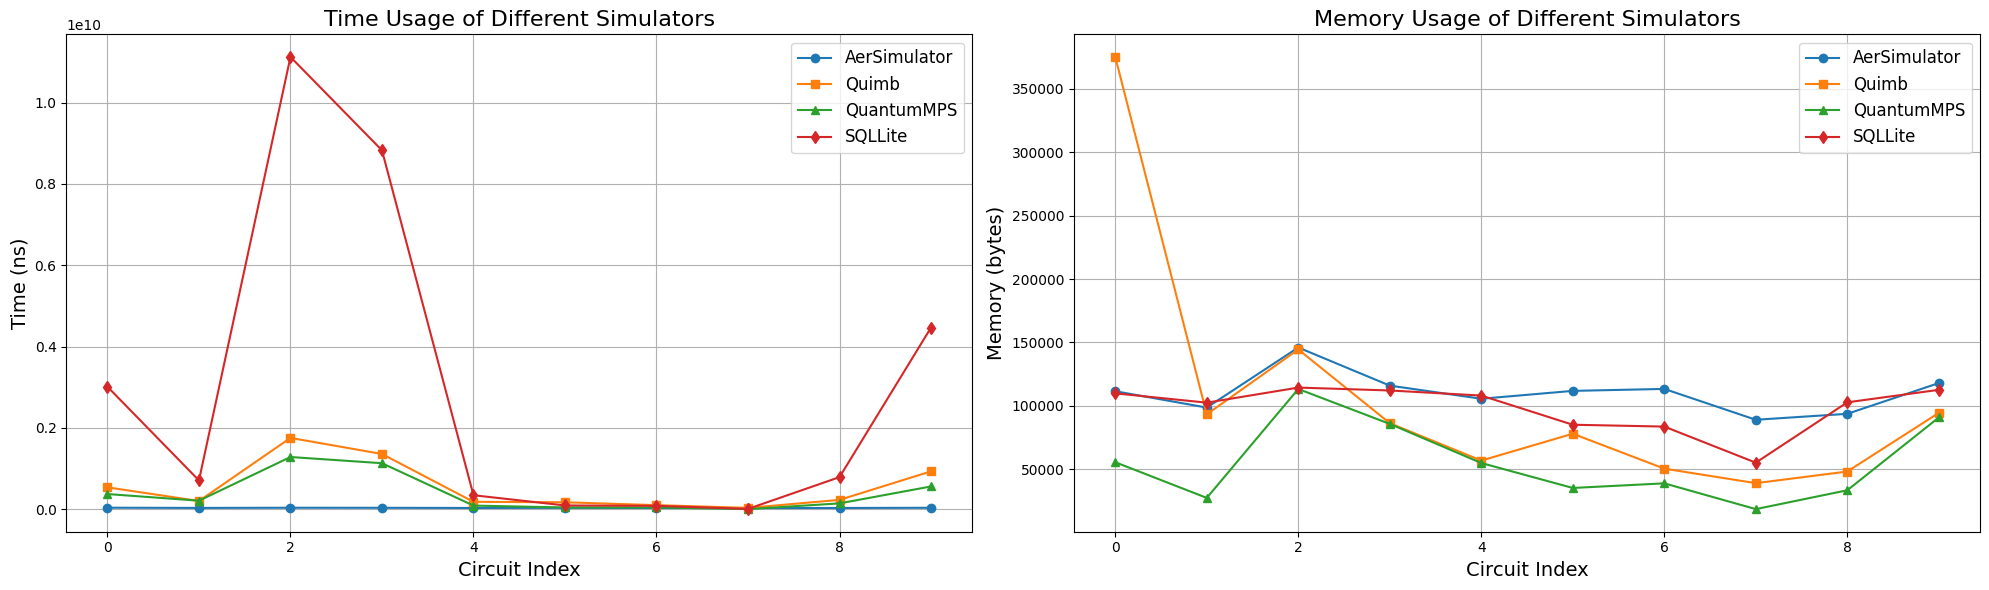

In [143]:
# Plot time and memory usage side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Define a color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot time usage
axs[0].plot(time_aer, label='AerSimulator', color=colors[0], marker='o')
axs[0].plot(time_quimb, label='Quimb', color=colors[1], marker='s')
axs[0].plot(time_qtn_sim, label='QuantumMPS', color=colors[2], marker='^')
axs[0].plot(time_rdbms, label='SQLLite', color=colors[3], marker='d')
axs[0].set_xlabel('Circuit Index', fontsize=14)
axs[0].set_ylabel('Time (ns)', fontsize=14)
axs[0].set_title('Time Usage of Different Simulators', fontsize=16)
axs[0].legend(fontsize=12)
axs[0].grid(True)

# Plot memory usage
axs[1].plot(mem_aer, label='AerSimulator', color=colors[0], marker='o')
axs[1].plot(mem_quimb, label='Quimb', color=colors[1], marker='s')
axs[1].plot(mem_qtn_sim, label='QuantumMPS', color=colors[2], marker='^')
axs[1].plot(mem_rdbms, label='SQLLite', color=colors[3], marker='d')
axs[1].set_xlabel('Circuit Index', fontsize=14)
axs[1].set_ylabel('Memory (bytes)', fontsize=14)
axs[1].set_title('Memory Usage of Different Simulators', fontsize=16)
axs[1].legend(fontsize=12)
axs[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [144]:
# Update or insert 'n' column
if 'n' in df_results.columns:
    df_results['n'] = n_list
else:
    df_results.insert(0, 'n', n_list)

# Calculate the probability of adjacent qubit gates for each circuit
actualp_list = []
for circuit in circuitsRead:
    adjacent_count = 0
    total_gates = len(circuit.gateList)
    
    for gate, indices in circuit.gateList:
        if max(indices) - min(indices) + 1 == len(gate.tensor.shape)/2:
            adjacent_count += 1
    
    actualp_list.append((float(adjacent_count) / float(total_gates)) if total_gates > 0 else 0)
# Update or insert 'p' column
if 'p' in df_results.columns:
    df_results['p'] = actualp_list
else:
    df_results.insert(1, 'p', actualp_list)

# Update or insert 'd' column
if 'd' in df_results.columns:
    df_results['d'] = d_list
else:
    df_results.insert(2, 'd', d_list)

In [145]:
def determine_best_simulation(row):
    simulators = ['aer', 'quimb', 'qtn_sim', 'sqlite']
    time_cols = ['time_aer', 'time_quimb', 'time_qtn_sim', 'time_rdbms']
    mem_cols = ['mem_aer', 'mem_quimb', 'mem_qtn_sim', 'mem_rdbms']
    
    best_sim = None
    best_time = float('inf')
    best_mem = float('inf')
    
    for sim, time_col, mem_col in zip(simulators, time_cols, mem_cols):
        if row[time_col] < best_time:
            best_sim = sim
            best_time = row[time_col]
            best_mem = row[mem_col]
        # if row[time_col] < best_time and row[mem_col] < best_mem:
        #     best_sim = sim
        #     best_time = row[time_col]
        #     best_mem = row[mem_col]
        # else:
        #     # Rank the simulators based on time and memory
        #     time_ranks = {sim: rank for rank, sim in enumerate(sorted(simulators, key=lambda s: row[time_cols[simulators.index(s)]]))}
        #     mem_ranks = {sim: rank for rank, sim in enumerate(sorted(simulators, key=lambda s: row[mem_cols[simulators.index(s)]]))}
            
        #     # Calculate the average rank for each simulator
        #     avg_ranks = {sim: (time_ranks[sim] + mem_ranks[sim]) / 2 for sim in simulators}
            
        #     # Find the simulator with the lowest average rank
        #     best_sim = min(avg_ranks, key=avg_ranks.get)
    
    return best_sim

df_results['best_simulation'] = df_results.apply(determine_best_simulation, axis=1)

df_results.to_csv("simulationData.csv")

In [146]:
best_simulation_counts = df_results['best_simulation'].value_counts()
print(best_simulation_counts)

best_simulation
aer        9
qtn_sim    1
Name: count, dtype: int64


In [147]:
# Count the number of times each simulator was the best based on time and memory
best_time_counts = df_results[['time_aer', 'time_quimb', 'time_qtn_sim', 'time_rdbms']].idxmin(axis=1).value_counts()
best_mem_counts = df_results[['mem_aer', 'mem_quimb', 'mem_qtn_sim', 'mem_rdbms']].idxmin(axis=1).value_counts()

# Map the column names to simulator names
simulator_map = {
    'time_aer': 'AerSimulator',
    'time_quimb': 'Quimb',
    'time_qtn_sim': 'QuantumMPS',
    'time_rdbms': 'SQLLite',
    'mem_aer': 'AerSimulator',
    'mem_quimb': 'Quimb',
    'mem_qtn_sim': 'QuantumMPS',
    'mem_rdbms': 'SQLLite'
}

# Print the results
print("Best on Time:")
for sim, count in best_time_counts.items():
    print(f"{simulator_map[sim]}: {count}")

print("\nBest on Memory:")
for sim, count in best_mem_counts.items():
    print(f"{simulator_map[sim]}: {count}")

Best on Time:
AerSimulator: 9
QuantumMPS: 1

Best on Memory:
QuantumMPS: 10


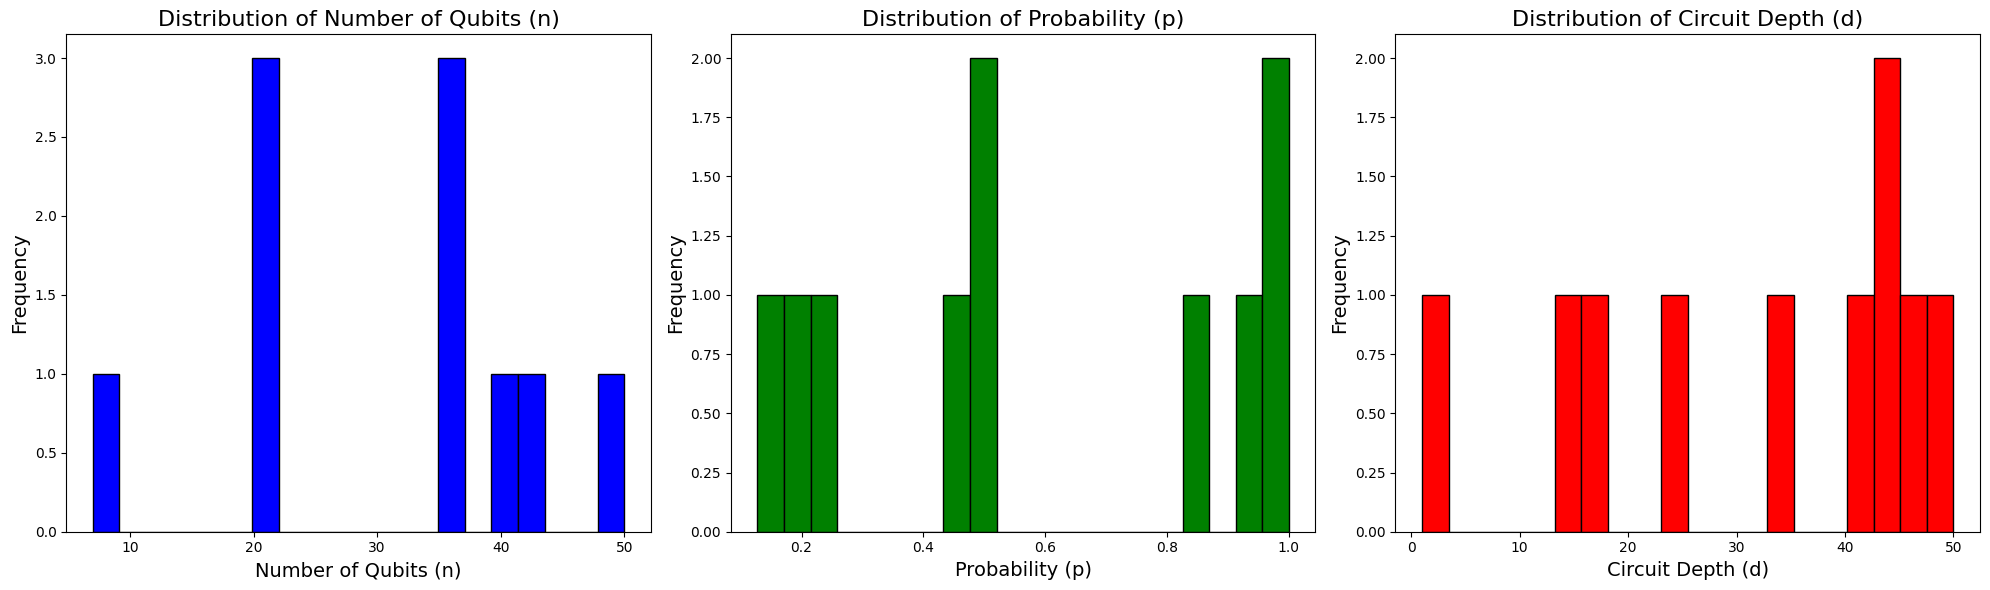

In [148]:
# Draw histogram distributions for n, p, and d
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Histogram for n
axs[0].hist(n_list, bins=20, color='blue', edgecolor='black')
axs[0].set_xlabel('Number of Qubits (n)', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].set_title('Distribution of Number of Qubits (n)', fontsize=16)

# Histogram for p
axs[1].hist(actualp_list, bins=20, color='green', edgecolor='black')
axs[1].set_xlabel('Probability (p)', fontsize=14)
axs[1].set_ylabel('Frequency', fontsize=14)
axs[1].set_title('Distribution of Probability (p)', fontsize=16)

# Histogram for d
axs[2].hist(d_list, bins=20, color='red', edgecolor='black')
axs[2].set_xlabel('Circuit Depth (d)', fontsize=14)
axs[2].set_ylabel('Frequency', fontsize=14)
axs[2].set_title('Distribution of Circuit Depth (d)', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()